In [21]:
from pycalphad import Database
from pycalphad.io import tdb
from pycalphad import Database, calculate, equilibrium, Workspace, binplot, variables as v
from tinydb import Query


def add_two_database(db, db_2):
    db.species = db.species.union(db_2.species)
    db.elements = db.elements.union(db_2.elements)

    # Add phases into the database
    for phase_name in db_2.phases:
        # Add a phase not present in the first database
        if phase_name not in db.phases:
            db.add_phase(
                db_2.phases[phase_name].name, 
                db_2.phases[phase_name].model_hints, 
                db_2.phases[phase_name].sublattices
            )

            constituent_array = []
            for sublattice in (db_2.phases[phase_name].constituents):
                sublattice_list = []
                for constintuent in sublattice:
                    sublattice_list.append(constintuent.name)  

                constituent_array.append(sublattice_list)

            db.add_phase_constituents(db_2.phases[phase_name].name, constituent_array)
        
        # Add to an existing phase in database
        else:
            print(phase_name, ' is dublicated')


            constituent_array = []
            for sublattice in (db.phases[phase_name].constituents):
                sublattice_list = []
                for constintuent in sublattice:
                    sublattice_list.append(constintuent.name)  

                constituent_array.append(sublattice_list)
            
            for sublattice_index in range(len(db_2.phases[phase_name].constituents)):
                # print(constituent_array[sublattice_index])
                for i in db_2.phases[phase_name].constituents[sublattice_index]:
                    constituent_array[sublattice_index].append(i.name)

            # Check if the models used in the phase are the same and select one if not.
            if db.phases[phase_name].model_hints != db_2.phases[phase_name].model_hints:
                print('different models! \ndb_1 has the following model: {}\ndb_2 hast the following model: {}'.format(
                    db.phases[phase_name].model_hints, 
                    db_2.phases[phase_name].model_hints)
                )

                print('Type 1 for :{} \nType 2 for: {}'.format(db.phases[phase_name].model_hints, db_2.phases[phase_name].model_hints))
                user_input = int(input())

                if user_input == 1:
                    db.phases[phase_name].model_hints = db.phases[phase_name].model_hints
                elif user_input == 2:
                    db.phases[phase_name].model_hints = db_2.phases[phase_name].model_hints
                else:
                    print('Incorret input')
                    break

            db.add_phase_constituents(db_2.phases[phase_name].name, constituent_array)

    # Add parameters to the phases just added. 
    for parameter in db_2._parameters.all():
        constituent_array = []
        for sublattice in parameter['constituent_array']:
            sublattice_constituents = []
            for species in sublattice:
                sublattice_constituents.append(species.name)
            constituent_array.append(sublattice_constituents)

        pareameter_query = Query()

        # Check if an identical parameter is present
        if len(db._parameters.search(
            pareameter_query.parameter == parameter['parameter']
        )) == 0:
            
            # Check if a different parameter is present for the same species
            if len(db._parameters.search((pareameter_query.phase_name == parameter['phase_name']) &
                        (pareameter_query.parameter_type == parameter['parameter_type']) &
                        (pareameter_query.constituent_array == parameter['constituent_array']) &
                        (pareameter_query.parameter_order == parameter['parameter_order'])                        
                    )
            ) != 0:
                
                # get the parameter from the original database 
                parameter_db_1 = db._parameters.search((pareameter_query.phase_name == parameter['phase_name']) &
                        (pareameter_query.parameter_type == parameter['parameter_type']) &
                        (pareameter_query.constituent_array == parameter['constituent_array']) &
                        (pareameter_query.parameter_order == parameter['parameter_order'])                        
                    )[0]
                
                # displace the information for the user
                print('Dupicate parameters! for phase: {}, type: {}, constituents: {})'.format(parameter['phase_name'], parameter['parameter_type'], parameter['constituent_array']))

                print('Type 1 for: {} \nType 2 for: {}'.format(parameter_db_1['parameter'], parameter['parameter']))
                user_input = int(input())

                if user_input == 1:
                    parameter['parameter'] = parameter_db_1['parameter']
                elif user_input == 2:
                    pass
                else:
                    print('Incorret input')
                    break
                
                db.add_parameter(
                    parameter['parameter_type'],
                    parameter['phase_name'],
                    constituent_array,
                    parameter['parameter_order'],
                    parameter['parameter'],
                    parameter['reference'],
                    parameter['diffusing_species'],
                    force_insert=True
                )




    for ref_state in db_2.refstates:
        if ref_state not in db.refstates:
            db.refstates[ref_state] = db_2.refstates[ref_state]

    for symbol in db_2.symbols:
        if symbol not in db.symbols:
            db.symbols[symbol] = db_2.symbols[symbol]

    return db

In [22]:
db_alfe = Database('G:/My Drive/Shared/MORRE_databases/tdb_files/nims_alfe.tdb')
db_almg = Database('G:/My Drive/Shared/MORRE_databases/tdb_files/nims_almg.tdb')

db_alfemg = add_two_database(db_alfe, db_almg)

LIQUID  is dublicated
different models! 
db_1 has the following model: {}
db_2 hast the following model: {'liquid': True}
Type 1 for :{} 
Type 2 for: {'liquid': True}


ValueError: invalid literal for int() with base 10: ''

<Axes: title={'center': 'Al-Fe'}, xlabel='X(Al)', ylabel='Temperature'>

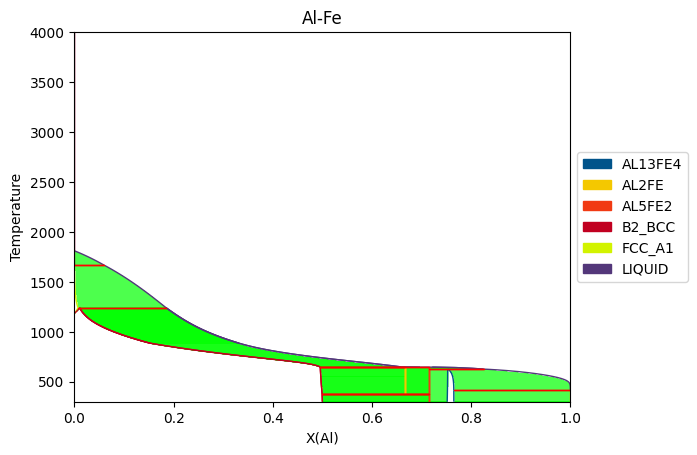

In [20]:
comp = ['AL', 'FE', 'VA']
phases = db_alfemg.phases

binplot(db_alfemg, comp, phases, {v.T:(300,4000,10), v.P:101325, v.N:1, v.X('AL'):(0,1,0.1)})

<Axes: title={'center': 'Al-Mg'}, xlabel='X(Al)', ylabel='Temperature'>

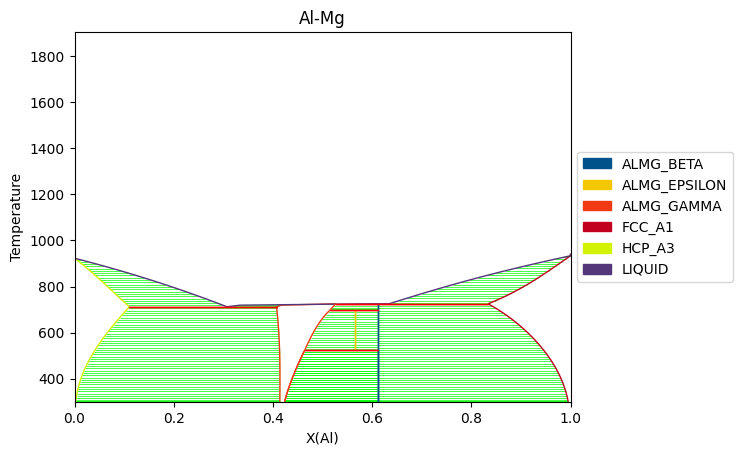

In [10]:
db_2 = Database('G:/My Drive/Shared/MORRE_databases/tdb_files/nims_almg.tdb')

comp = ['AL', 'mg', 'VA']
phases = db_1.phases

binplot(db_1, comp, phases, {v.T:(300,4000,10), v.P:101325, v.N:1, v.X('AL'):(0,1,0.1)})

LIQUID  is dublicated
different models! 
db_1 has the following model: {}
db_2 hast the following model: {'liquid': True}
FCC_A1  is dublicated
different models! 
db_1 has the following model: {'ihj_magnetic_afm_factor': -3.0, 'ihj_magnetic_structure_factor': 0.28}
db_2 hast the following model: {}
HCP_A3  is dublicated
different models! 
db_1 has the following model: {'ihj_magnetic_afm_factor': -3.0, 'ihj_magnetic_structure_factor': 0.28}
db_2 hast the following model: {}
Dupicate parameters! for phase: LIQUID, type: G, constituents: ((Species('AL', 'AL1'),),))


<Axes: title={'center': 'Al-Mg'}, xlabel='X(Al)', ylabel='Temperature'>

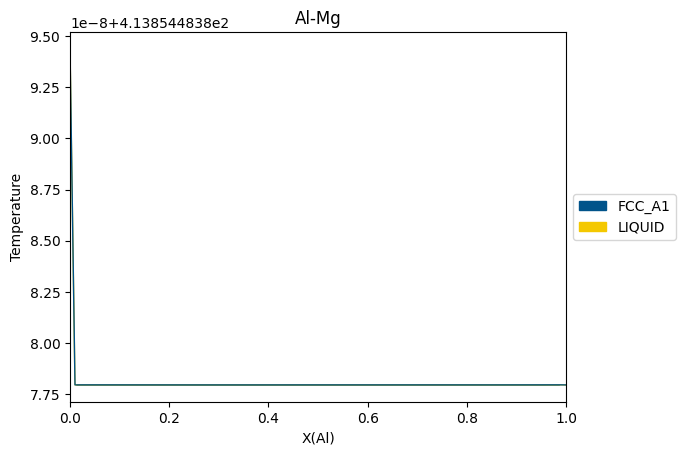

In [12]:
db = add_two_database(db_1, db_2)


<Axes: title={'center': 'Al-Mg'}, xlabel='X(Al)', ylabel='Temperature'>

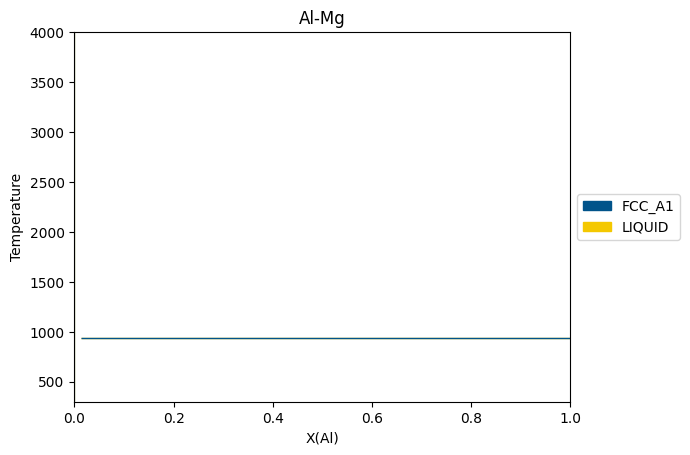

In [19]:

comp = ['AL', 'MG', 'VA']
phases = db.phases

binplot(Database('databases/outward_alfemg.tdb'), comp, phases, {v.T:(300,4000,10), v.P:101325, v.N:1, v.X('AL'):(0,1,0.1)})

In [16]:
db_1.to_file('databases/nims_alfe.tdb')
db.to_file('databases/outward_alfemg.tdb')